In [1]:
from transformer_lens import (HookedTransformer, utils)
from transformer_lens.hook_points import HookPoint
import functools
import torch
import matplotlib.pyplot as plt
from jaxtyping import Float, Int
from torch import Tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import PatchTSTForPrediction
from transformers.models.patchtst.modeling_patchtst import (
    PatchTSTForPredictionOutput
)

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error)
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from data_loader import *
import datasets
import pandas as pd
from scipy.stats import pearsonr

In [2]:
# patchtst = HookedTransformer.from_pretrained("patchtst")
# patchtst_transformer = PatchTSTForPrediction.from_pretrained("../models/patchtst_tsmixup_final").to(device)

patchtst = HookedTransformer.from_pretrained("patchtst_relu", center_unembed=False)
patchtst_transformer = PatchTSTForPrediction.from_pretrained("Coaster41/patchtst-tsmixup-relu").to(device)

model.safetensors:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Loaded pretrained model patchtst_relu into HookedTransformer


# Can we predict period from MLP activations?

In [29]:
def generate_sin(a, p):
    rows = p.shape[0] if torch.is_tensor(p) else 1
    b = 2*torch.pi / p
    return a * torch.sin(torch.arange(512).repeat(rows, 1) * b[:, None]).to(device)
a = 10
p = torch.arange(4, 101)
x = generate_sin(a, p)

def get_activations(
    attn_pattern: Float[Tensor, "batch num_patches d_mlp"],
    hook: HookPoint,
    activations: Float[Tensor, "batch num_patches d_mlp"]
) -> Float[Tensor, "batch num_patches d_mlp"]:
    activations[:] = attn_pattern
    return attn_pattern

def ar_predictions(model, x, pred_length=96, ctx_len=None, out_len=None):
    if ctx_len is None:
        ctx_len = model.cfg.n_ctx
    if out_len is None:
        out_len = model.cfg.prediction_length
    y = []
    with torch.no_grad():
        for i in range(pred_length // out_len):
            if i > 0:
                x = torch.cat((x[:, out_len:], y[-1]), dim=1)
            out = model(x)
            if isinstance(out, PatchTSTForPredictionOutput):
                out = out.prediction_outputs
            y.append(out)
        
    return torch.cat(y, dim=1)

In [30]:
# Run model with activations
mlp_activations = []
mlp_hooks = []
for i in range(patchtst.cfg.n_layers):
    mlp_activation = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
    mlp_activations.append(mlp_activation)
    get_mlp_activations = functools.partial(get_activations, activations=mlp_activation)
    mlp_hooks.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations))

y = patchtst.run_with_hooks(x, fwd_hooks=mlp_hooks)

In [8]:
# Train a LR models to predict period
layer = 0
patch = [31]
trials = 1000
lr = False
if lr:
    mae = []
    mse = []

lasso = False
if lasso:
    lasso_mae = []
    lasso_mse = []
    lasso_sparse = []

X = mlp_activations[layer][:, patch].flatten(start_dim=1).detach().cpu()


for trial in tqdm(range(trials)):
    X_train, X_test, y_train, y_test = train_test_split(X, p, test_size=0.1)

    # standard LR
    if lr:
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        mae.append(mean_absolute_error(y_test, y_pred))
        mse.append(mean_squared_error(y_test, y_pred))

    # Lasso
    if lasso:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lasso_cv = LassoLarsCV()
        lasso_cv.fit(X_train_scaled, y_train)
        y_lasso = lasso_cv.predict(X_test)
        lasso_mae.append(mean_absolute_error(y_test, y_lasso))
        lasso_mse.append(mean_squared_error(y_test, y_lasso))
        lasso_sparse.append(np.sum(lasso_cv.coef_ != 0))
    

  0%|          | 1/1000 [00:01<16:50,  1.01s/it]/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 233 iterations, alpha=3.461e-04, previous alpha=3.453e-04, with an active set of 68 regressors.
  warnings.warn(
/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 122 iterations, alpha=1.850e-02, previous alpha=1.830e-02, with an active set of 47 regressors.
  warnings.warn(
  0%|          | 2/1000 [00:02<19:02,  1.14s/it]/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:753: Co

In [9]:
# LR using entire batch
layer = 0
patch = [31]
X = mlp_activations[layer][:, patch].flatten(start_dim=1).detach().cpu()

reg = LinearRegression().fit(X, p)
y_pred = reg.predict(X)
print(f"LR MAE: {mean_absolute_error(p, y_pred):.3f} MSE: {mean_squared_error(p, y_pred):.3f}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso_cv = LassoLarsCV()
lasso_cv.fit(X_scaled, p)
y_pred = lasso_cv.predict(X_scaled)
print(f"Lasso LR MAE: {mean_absolute_error(p, y_pred):.3f} MSE: {mean_squared_error(p, y_pred):.3f} Non-zero coef: {np.sum(lasso_cv.coef_ != 0)}")

LR MAE: 0.000 MSE: 0.000


/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 237 iterations, i.e. alpha=5.921e-04, with an active set of 73 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 274 iterations, alpha=2.960e-04, previous alpha=2.960e-04, with an active set of 75 regressors.
  warnings.warn(


Lasso LR MAE: 0.544 MSE: 0.546 Non-zero coef: 64


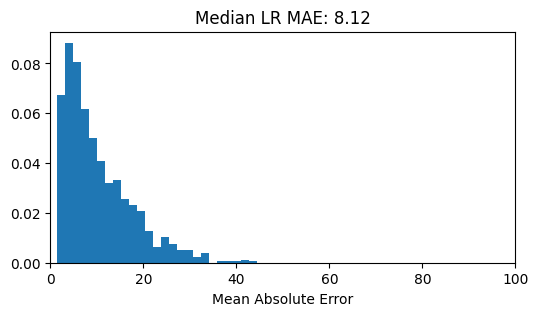

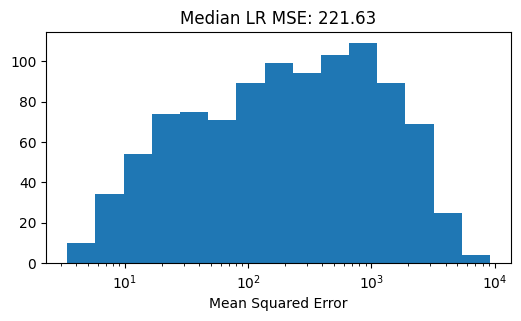

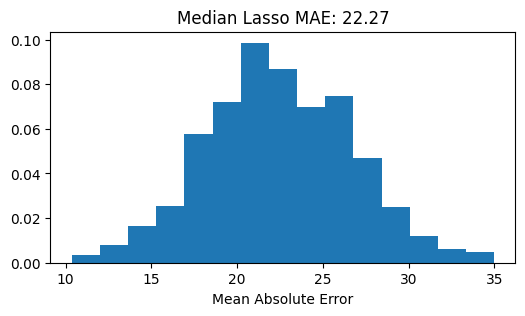

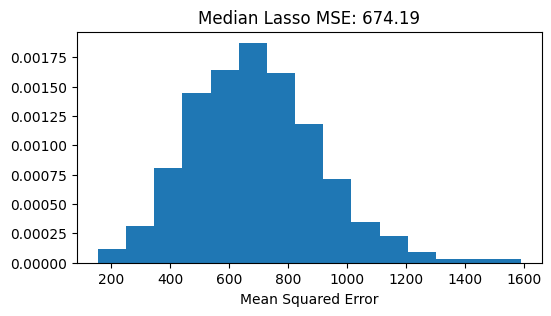

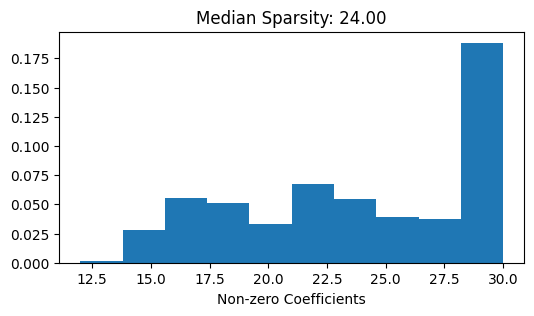

In [10]:
# Plot LR Histograms
plt.figure(figsize=(6,3))
plt.hist(np.clip(mae, a_min=0, a_max=100), bins=25, density=True)
plt.title(f"Median LR MAE: {np.median(mae):.2f}")
plt.xlabel("Mean Absolute Error")
plt.xlim(0,100)
plt.show()

plt.figure(figsize=(6,3))
hist, bins = np.histogram(np.clip(mse, a_min=0, a_max=50000), bins=15, density=False)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(np.clip(mse, a_min=0, a_max=50000), bins=logbins, density=False)
plt.title(f"Median LR MSE: {np.median(mse):.2f}")
plt.xscale('log')
plt.xlabel("Mean Squared Error")
plt.show()


plt.figure(figsize=(6,3))
plt.hist(np.clip(lasso_mae, a_min=0, a_max=35), bins=15, density=True)
plt.title(f"Median Lasso MAE: {np.median(lasso_mae):.2f}")
plt.xlabel("Mean Absolute Error")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(np.clip(lasso_mse, a_min=0, a_max=2000), bins=15, density=True)
plt.title(f"Median Lasso MSE: {np.median(lasso_mse):.2f}")
plt.xlabel("Mean Squared Error")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(np.clip(lasso_sparse, a_min=0, a_max=30), bins=10, density=True)
plt.title(f"Median Sparsity: {np.median(lasso_sparse):.2f}")
plt.xlabel("Non-zero Coefficients")
plt.show()

In [33]:
# Get Pearson Correlation
corr = torch.zeros((patchtst.cfg.n_layers, patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
for layer in range(patchtst.cfg.n_layers):
    for patch in tqdm(range(patchtst.cfg.num_patches)):
        for neuron in range(patchtst.cfg.d_mlp):
            correlation, _ = pearsonr(mlp_activations[layer][:, patch, neuron].detach().cpu(), p)
            corr[layer, patch, neuron] = abs(correlation)

corr = torch.nan_to_num(corr, 0)

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_250195/3454491495.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(mlp_activations[layer][:, patch, neuron].detach().cpu(), p)
100%|██████████| 32/32 [00:02<00:00, 15.47it/s]


Correlation: 0.932 layer: 1, patch: 0, neuron: 203
Correlation: 0.912 layer: 1, patch: 2, neuron: 17
Correlation: 0.897 layer: 0, patch: 1, neuron: 212
Correlation: 0.896 layer: 1, patch: 0, neuron: 103
Correlation: 0.876 layer: 0, patch: 1, neuron: 179
Correlation: 0.874 layer: 1, patch: 0, neuron: 55
Correlation: 0.871 layer: 0, patch: 0, neuron: 192
Correlation: 0.868 layer: 0, patch: 0, neuron: 208
Correlation: 0.859 layer: 2, patch: 1, neuron: 32
Correlation: 0.855 layer: 0, patch: 0, neuron: 97
Error when predicting from the best neuron
MAE: 8.28 MSE: 102.92


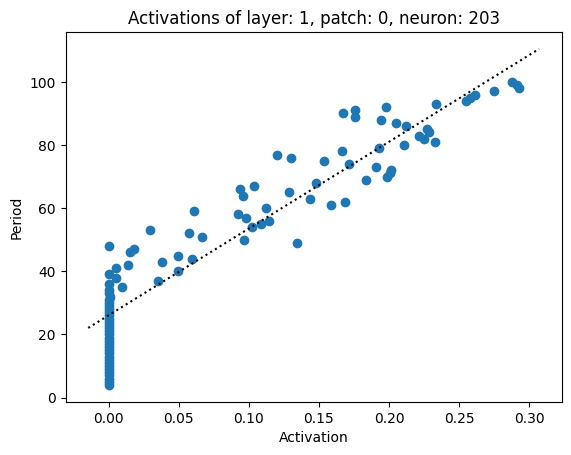

In [34]:
# Get Correlation of neurons with period
k = 10
top10_values, top10_ind = torch.topk(corr.flatten(), k=k)
for val, ind in zip(top10_values, top10_ind):
    layer, patch, neuron = torch.unravel_index(ind, corr.shape)
    print(f"Correlation: {val:.3f} layer: {layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}")
    
# Plot best activations against period
global_argmax = torch.argmax(corr)
layer, patch, neuron = torch.unravel_index(global_argmax, corr.shape)

X = mlp_activations[layer][:, patch, neuron][:,None].detach().cpu()
reg = LinearRegression().fit(X, p)
y_pred = reg.predict(X)
print("Error when predicting from the best neuron")
print(f"MAE: {mean_absolute_error(p, y_pred):.2f} MSE: {mean_squared_error(p, y_pred):.2f}")


plt.scatter(mlp_activations[layer][:, patch, neuron].detach().cpu(), p)
plt.ylabel("Period")
plt.xlabel("Activation")
xmin, xmax = plt.xlim()
plt.plot([xmin, xmax], reg.predict([[xmin], [xmax]]), c='black', ls=':')
plt.title(f"Activations of layer: {layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}")
plt.show()

In [35]:
# Does the neuron with the highest correlation the same over patches
max_val, max_ind = torch.max(corr, dim=2)
neuron_corr = torch.mean(corr, dim=1)
topk_avg, topk_ind = torch.topk(neuron_corr, k=5, dim=1)
for layer in range(max_val.shape[0]):
    print(f"Layer: {layer}")
    counts = torch.bincount(max_ind[layer])
    count_dict = {i: count.item() for i, count in enumerate(counts) if count > 0}
    sorted_by_count = dict(sorted(count_dict.items(), key=lambda x: x[1], reverse=True))
    print(f"Neurons with max correlation per patch: {sorted_by_count}")
    dict_topk = dict(zip(topk_ind[layer].tolist(), [float(f"{i:.3f}") for i in topk_avg[layer].tolist()]))
    print(f"Average Correlation with top neurons: {dict_topk}")

Layer: 0
Neurons with max correlation per patch: {212: 4, 104: 3, 239: 3, 9: 2, 73: 2, 133: 2, 160: 2, 175: 2, 215: 2, 25: 1, 49: 1, 130: 1, 132: 1, 147: 1, 170: 1, 184: 1, 192: 1, 240: 1, 248: 1}
Average Correlation with top neurons: {9: 0.385, 248: 0.383, 146: 0.382, 122: 0.369, 215: 0.367}
Layer: 1
Neurons with max correlation per patch: {251: 15, 208: 4, 102: 3, 188: 3, 17: 1, 91: 1, 93: 1, 168: 1, 203: 1, 247: 1, 249: 1}
Average Correlation with top neurons: {251: 0.641, 208: 0.62, 171: 0.567, 144: 0.564, 76: 0.563}
Layer: 2
Neurons with max correlation per patch: {27: 11, 209: 7, 168: 3, 200: 2, 24: 1, 32: 1, 66: 1, 115: 1, 138: 1, 151: 1, 192: 1, 232: 1, 250: 1}
Average Correlation with top neurons: {209: 0.603, 27: 0.59, 168: 0.558, 62: 0.549, 138: 0.541}


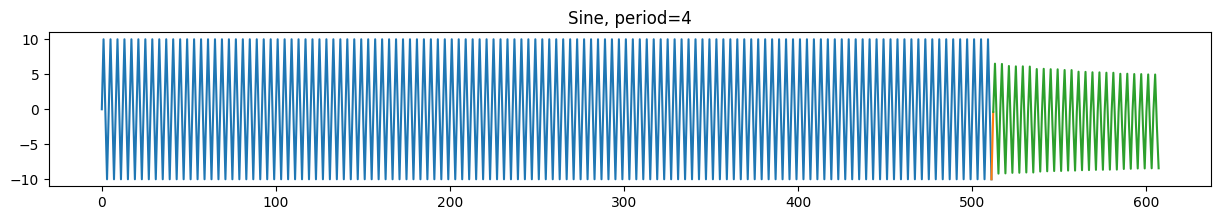

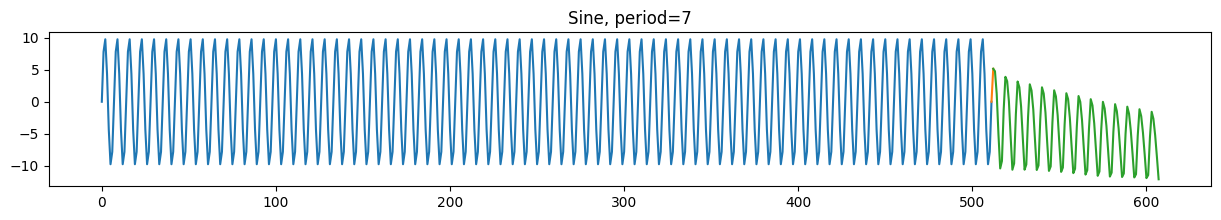

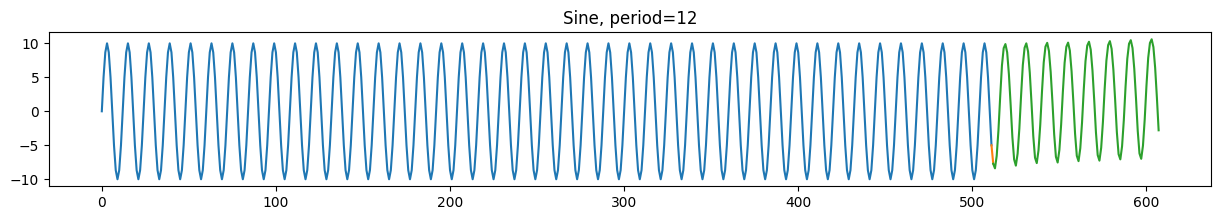

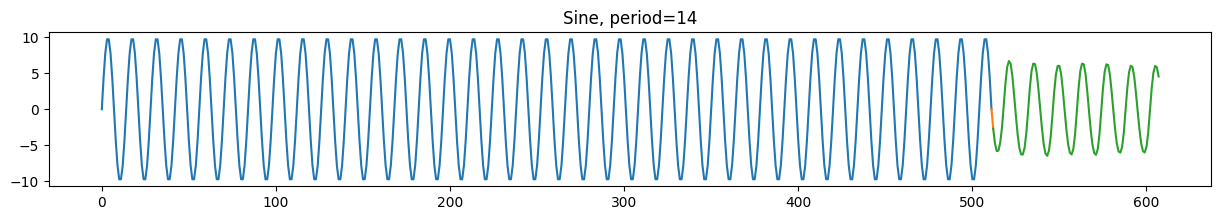

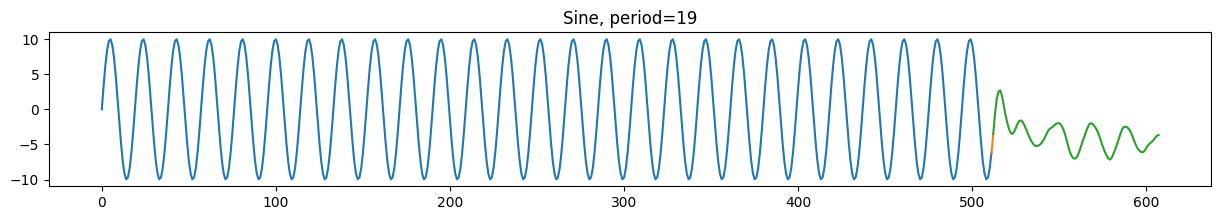

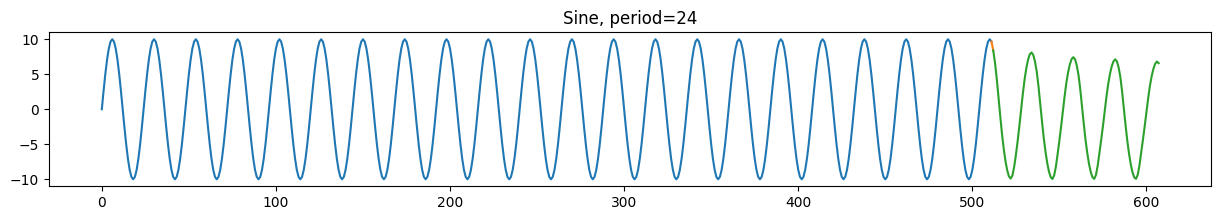

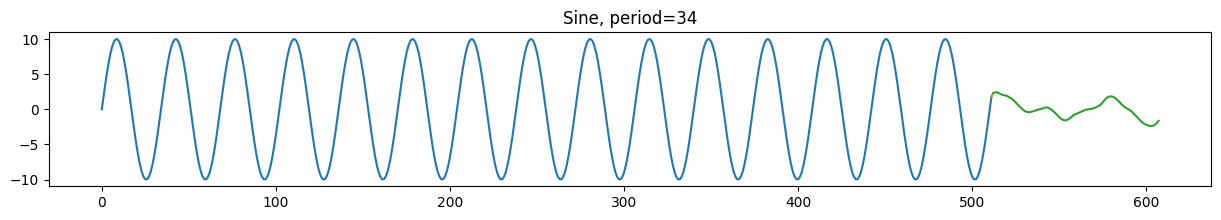

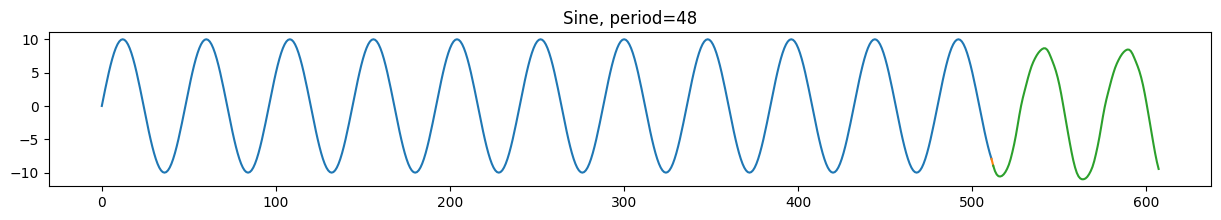

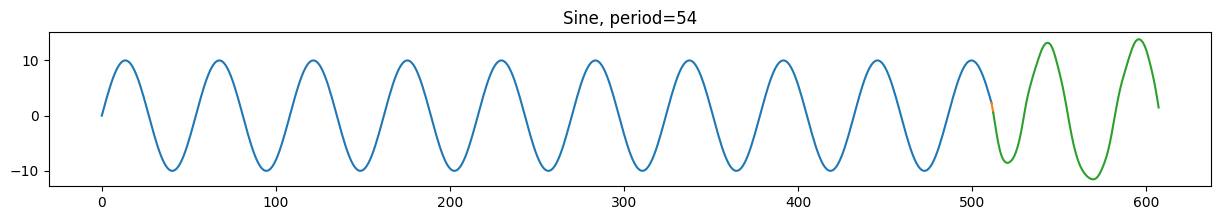

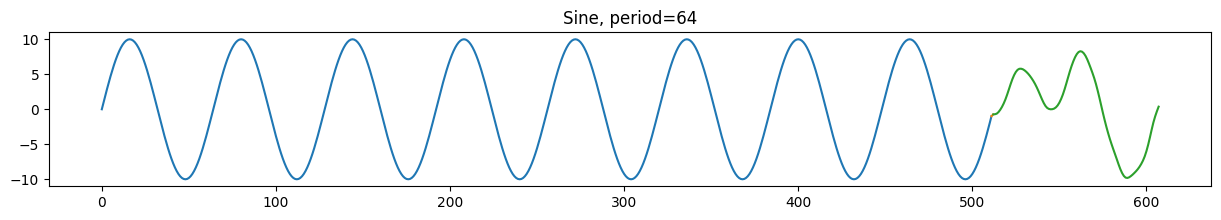

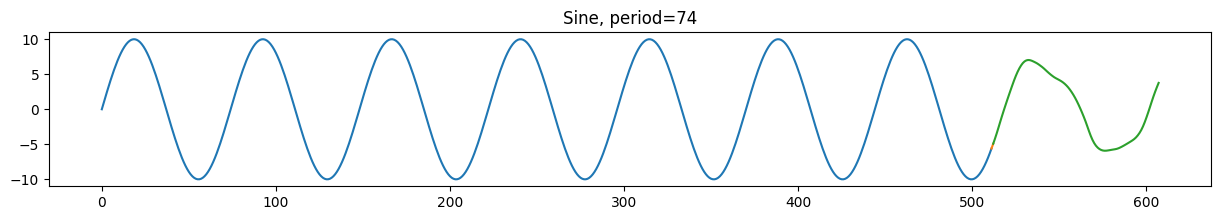

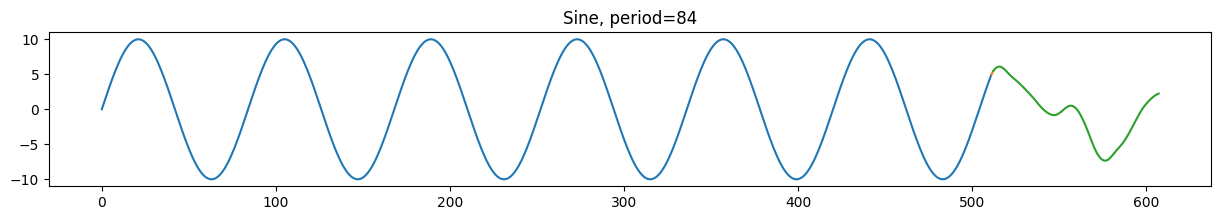

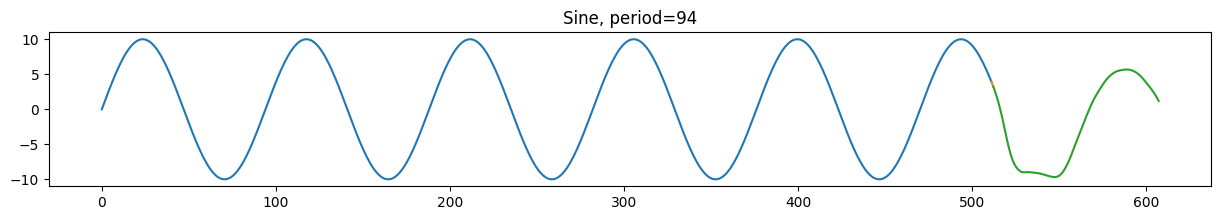

In [14]:
# Various Plots
y_ar = ar_predictions(patchtst, x)
y_ar_transformer = ar_predictions(patchtst_transformer, x[:,:,None], ctx_len=512, out_len=1)[:,:,0]

for batch in [0,3,8,10,15,20,30,44,50,60,70,80,90]:
    plt.figure(figsize=(15,2))
    plt.plot(x[batch].detach().cpu())
    plt.plot([511,512], [x[batch,-1].item(), y_ar[batch,0].item()])
    plt.plot(torch.arange(y_ar.shape[1]) + 512, y_ar[batch].detach().cpu().numpy())
    plt.title(f"Sine, period={p[batch]}")
    plt.show()

# What are the distribution of neuron activations?

In [36]:
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=96, # 1 or 96
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl",
        batch_size=4000
    )

🚀 CREATING CACHED TSMIXUP DATASETS
📂 Found existing processed data at /extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl
⚡ Loading preprocessed data from cache...
✅ Loaded 174,209 preprocessed samples
📅 Cache created: 2025-08-03 15:05:17

📊 DATASET SUMMARY:
  Total processed samples: 174,209
  Context length: 512
  Prediction length: 96
🔀 Shuffling data...
📈 Data split:
  Training samples: 156,788
  Validation samples: 17,421
  Train ratio: 90.0%
🏗️  Creating PyTorch datasets...
🏗️  Dataset created with 156,788 samples
📊 Augmentation: ON
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2043, mean=1320
  Value ranges: min=-49.2103, max=70.9532
  Value stats: mean=0.9038, std=2.2952
🏗️  Dataset created with 17,421 samples
📊 Augmentation: OFF
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2048, mean=1284
  Value ranges: min=-28.6077, max=79.0030
  Value

In [38]:
def load_dataset(dataset, ts=1000, pred_length=1):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'].flatten())
            y.append(val_dict['future_values'].flatten())
        x = torch.stack(x)[:, -512:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"../../ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,512:512+pred_length]
        x = x[:,:512]
    return x, y

def get_activations(
    attn_pattern: Float[Tensor, "batch num_patches d_mlp"],
    hook: HookPoint,
    activations: Float[Tensor, "batch num_patches d_mlp"]
) -> Float[Tensor, "batch num_patches d_mlp"]:
    activations[:] = attn_pattern
    return attn_pattern

In [91]:
# get activations on tsmixup
batch_size = 1000
activations = [[] for _ in range(patchtst.cfg.n_layers)]

for i in tqdm(range(len(val_dataset) // batch_size)):
    ts = torch.arange(batch_size) + batch_size * i
    x, _ =  load_dataset('tsmixup', 1000)
    mlp_activations = []
    mlp_hooks = []
    for i in range(patchtst.cfg.n_layers):
        mlp_activation = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
        mlp_activations.append(mlp_activation)
        get_mlp_activations = functools.partial(get_activations, activations=mlp_activation)
        mlp_hooks.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations))

    y = patchtst.run_with_hooks(x, fwd_hooks=mlp_hooks)
    for i in range(patchtst.cfg.n_layers):
        activations[i].append(mlp_activations[i].detach().cpu())
        
all_activations = torch.stack([torch.cat(layer) for layer in activations])

100%|██████████| 17/17 [00:01<00:00, 11.02it/s]


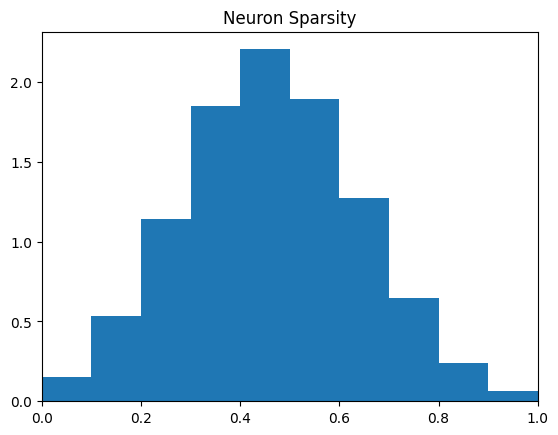

In [87]:
# get neuron sparsity
sparsity = torch.zeros((patchtst.cfg.n_layers, patchtst.cfg.patch_length, patchtst.cfg.d_mlp))
for layer in range(patchtst.cfg.n_layers):
    for patch in range(patchtst.cfg.patch_length):
        for neuron in range(patchtst.cfg.d_mlp):
            sparsity[layer, patch, neuron] = torch.sum(all_activations[layer, :, patch, neuron] > 0) / all_activations.shape[1]
hist, bins, _ = plt.hist(sparsity.flatten(), bins=torch.arange(11)/10, density=True)
plt.xlim(0,1)
plt.title("Neuron Sparsity")
plt.show()

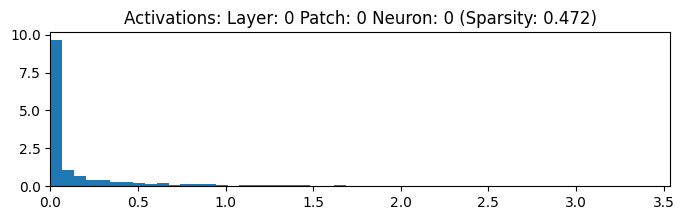

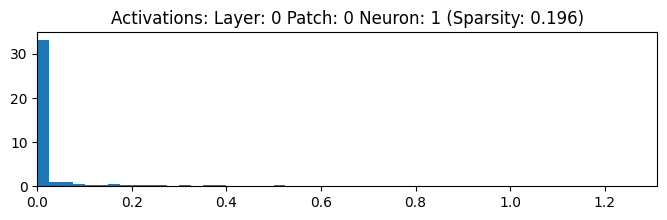

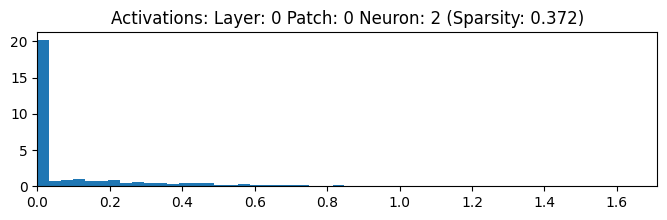

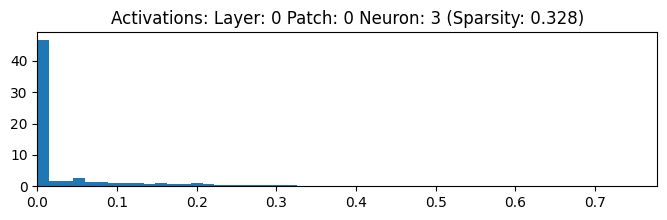

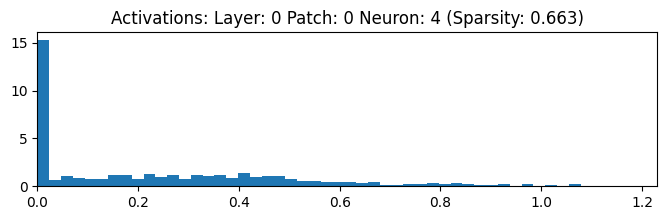

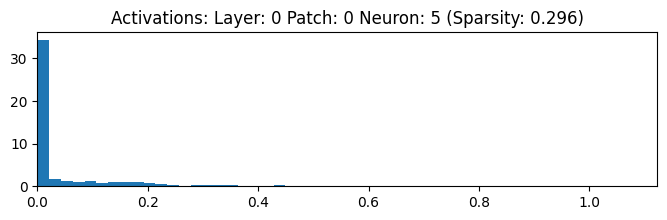

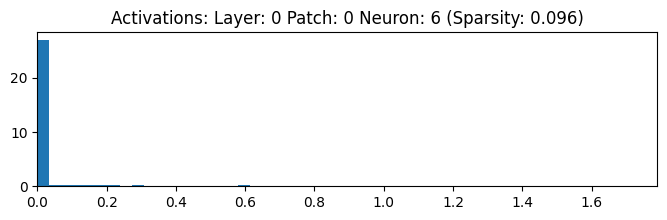

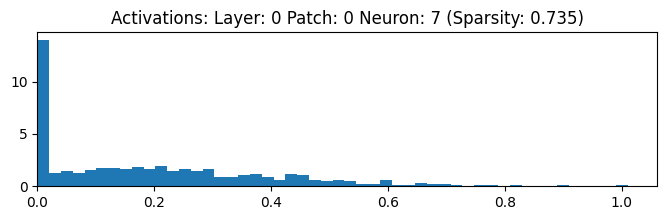

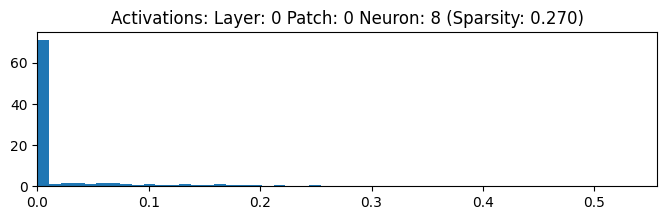

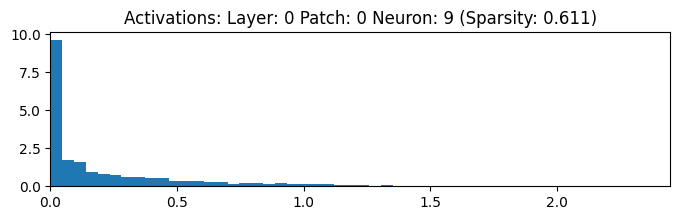

In [133]:
# Plot neuron activations
layer = 0
patch = 0
neuron = 0

for neuron in range(10):
    plt.figure(figsize=(8,2))
    hist, bins, _ = plt.hist(all_activations[layer, :, patch, neuron], bins=50, density=True)
    plt.xlim(0, None)
    plt.title(f"Activations: Layer: {layer} Patch: {patch} Neuron: {neuron} (Sparsity: {torch.mean((all_activations[layer, :, patch, neuron] > 0).float()):.3f})")
    plt.show()

#136 Time Series activate layer 1 patch 31 neuron 212


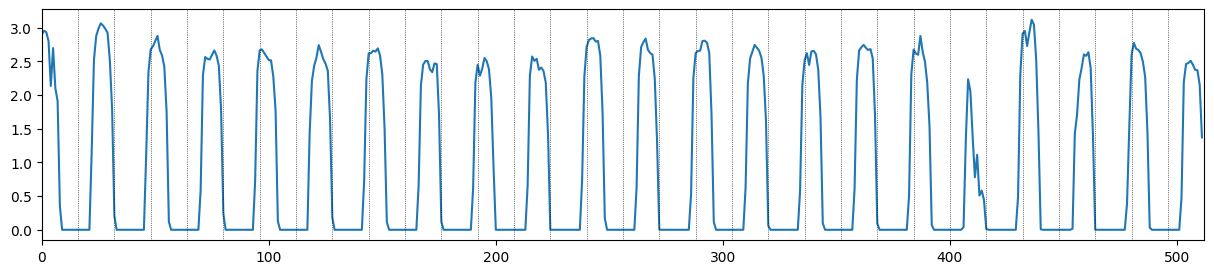

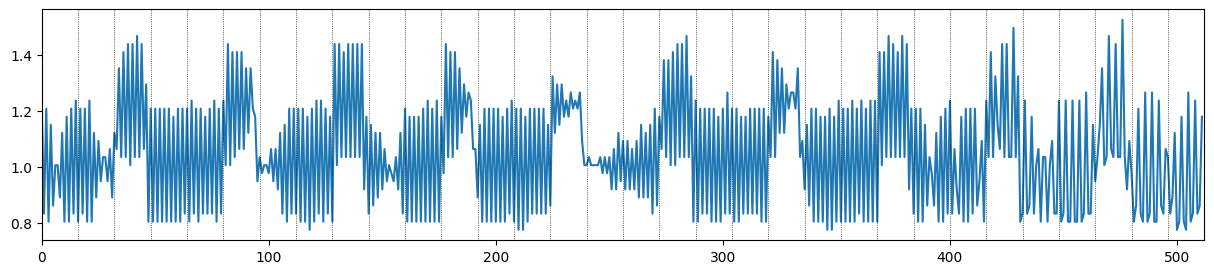

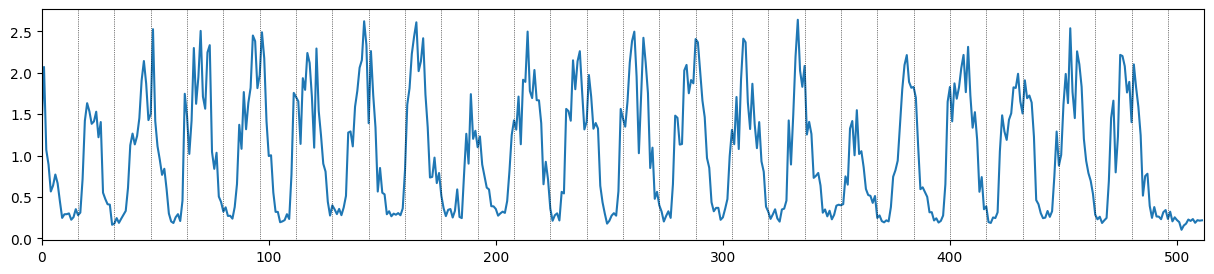

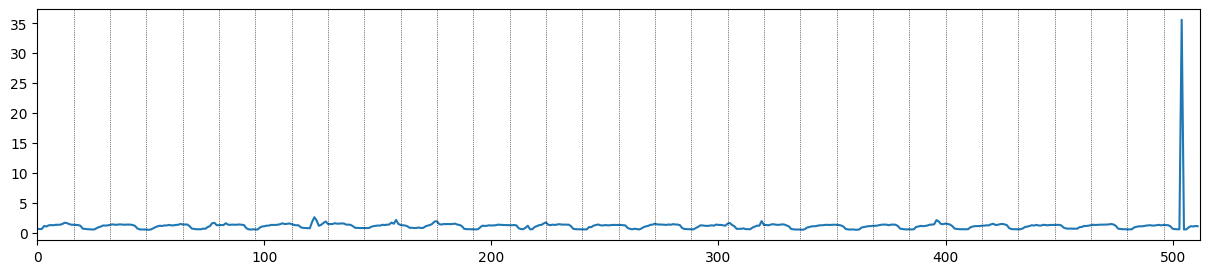

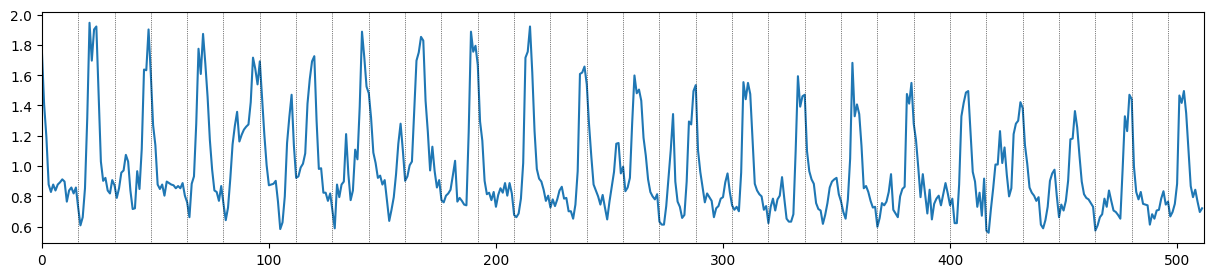

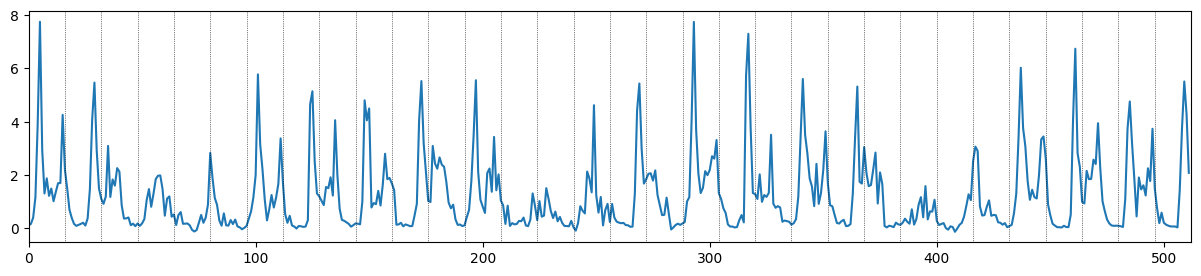

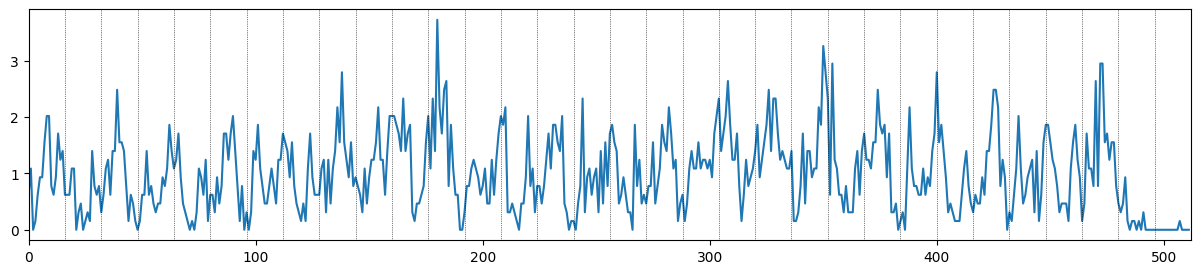

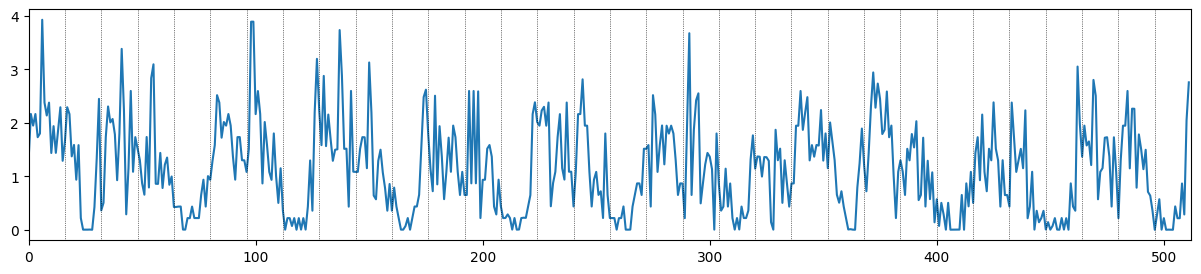

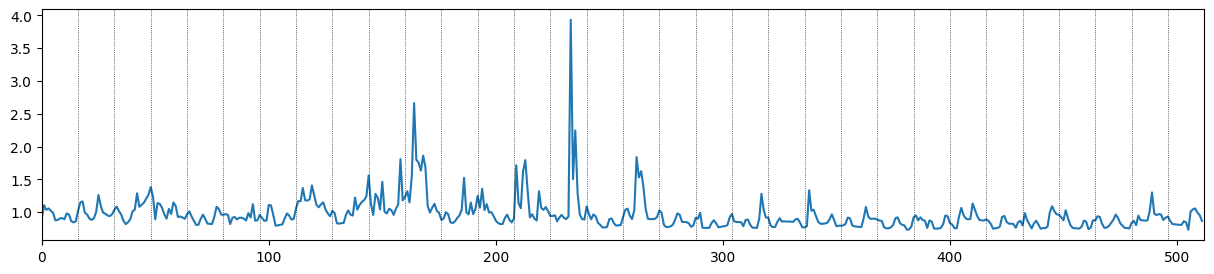

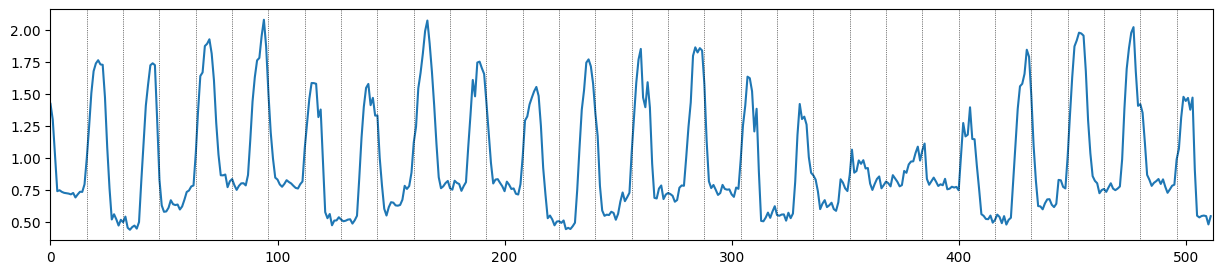

In [ ]:
layer = 1
patch = 31
neuron = 212
indicies = torch.nonzero(all_activations[layer, :, patch, neuron] > 0)
x, y = load_dataset('tsmixup', ts = indicies)
print(f"{x.shape[0]} Time Series activate layer {layer} patch {patch} neuron {neuron}")
for batch in range(10):
    plt.figure(figsize=(15,3))
    plt.plot(x[batch])
    for i in range(33):
        plt.axvline(16*i, lw=0.5, ls=':', c='black')
    plt.xlim(0,512)
    plt.show()